Importing stuff needed

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

Loading and transforming data (random crop and horizontal flip for the training dataset to improve performance)

In [12]:
#Defining transforms
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]) 

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#Loading CIFAR10 - first for training, second for testing
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Defining CNN

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.relu4 = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 256 * 4 * 4)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# determines device to train on - gpu or cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Net().to(device)

Loss function + Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Training the CNN

In [15]:
num_epochs = 20
train_losses = [] #store losses for training dataset
train_accs = [] #store accuracy for training dataset
test_losses = [] #store accuracy for test dataset
test_accs = [] #store accuracy for test dataset
for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    net.train()
    for i, data in enumerate(trainloader, 0):
        # Get input
        inputs, labels = data

        # Zero gradients
        optimizer.zero_grad()

        # Optimize and update
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # Calculate training loss and accuracy
    train_loss = train_loss / len(trainloader)
    train_acc = 100.0 * train_correct / train_total
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # Calculate test dataset loss and accuracy
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    net.eval()
    with torch.no_grad(): #no grad because we aren't using test dataset to train
        for data in testloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
    test_loss = test_loss / len(testloader)
    test_acc = 100.0 * test_correct / test_total
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Print progress every epoch
    print(f'Epoch {epoch+1:2d} | Train Loss: {train_loss:.3f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.3f} | Test Accuracy: {test_acc:.2f}%')

Epoch  1 | Train Loss: 1.730 | Train Accuracy: 37.05% | Test Loss: 1.377 | Test Accuracy: 50.50%
Epoch  2 | Train Loss: 1.392 | Train Accuracy: 49.52% | Test Loss: 1.201 | Test Accuracy: 57.80%
Epoch  3 | Train Loss: 1.250 | Train Accuracy: 54.97% | Test Loss: 1.057 | Test Accuracy: 62.66%
Epoch  4 | Train Loss: 1.142 | Train Accuracy: 59.19% | Test Loss: 1.009 | Test Accuracy: 64.15%
Epoch  5 | Train Loss: 1.072 | Train Accuracy: 62.02% | Test Loss: 0.918 | Test Accuracy: 67.59%
Epoch  6 | Train Loss: 1.014 | Train Accuracy: 63.87% | Test Loss: 0.907 | Test Accuracy: 67.99%
Epoch  7 | Train Loss: 0.969 | Train Accuracy: 65.94% | Test Loss: 0.817 | Test Accuracy: 71.59%
Epoch  8 | Train Loss: 0.929 | Train Accuracy: 67.19% | Test Loss: 0.816 | Test Accuracy: 71.54%
Epoch  9 | Train Loss: 0.894 | Train Accuracy: 68.54% | Test Loss: 0.792 | Test Accuracy: 72.57%
Epoch 10 | Train Loss: 0.865 | Train Accuracy: 69.52% | Test Loss: 0.750 | Test Accuracy: 73.59%
Epoch 11 | Train Loss: 0.846 |

Plot data

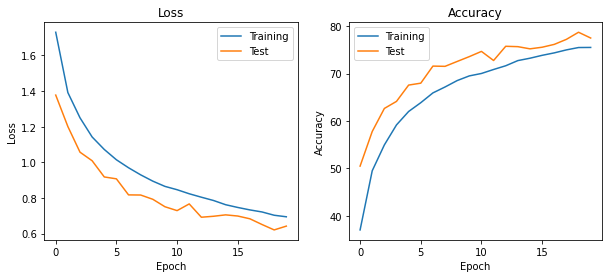

In [17]:
# For loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(test_losses, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()

# For accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training')
plt.plot(test_accs, label='Test')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()